In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline

# exploring sensitivity to initial winding number

$$\dot \theta_j = \omega_0 - \frac{K}{2} \left[ {\rm tanh} \left( \frac{ \cos\theta_{j-1} - \cos\theta_{j} - \beta}{h_{ol}} \right) + 1\right]  $$ 
$$ - \nu_p  \sin( \theta_j- \theta_{j+1}) -\nu_m \sin(\theta_j - \theta_{j-1})$$
$$ + \nu_{cp}  \cos( \theta_j- \theta_{j+1}) + \nu_{cm} \cos(\theta_j- \theta_{j-1})$$
$$ + A_c \cos(\theta_j + \theta_{j+1}) + A_s \sin(\theta_j + \theta_{j+1}) 
+ A_c \cos(\theta_j + \theta_{j-1}) + A_s \sin(\theta_j + \theta_{j-1})$$

The local Kuramoto model is $K_s = A_c = A_s = 0$ and $\nu >0$. 
The simple Niedermayer model has $\nu_p=\nu_p>0$ an $\nu_{cp} = \nu_{cm}>0$.

Sign or order of inside of $\nu_c$ cosine terms is irrelevant! 


This model encompases a vanilla phase oscillator model along with one sided overlap term and some terms
that involve sums of angles


$$ \cos(\theta_j + \theta_{j+1}  ) + \cos (\theta_j + \theta_{j-1})  = 2 \cos (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$ 
$$ \sin(\theta_j + \theta_{j+1}  ) + \sin (\theta_j + \theta_{j-1})  = 
2 \sin (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$

In [2]:
# functions for phase oscillator models 
# up is theta_j+1
# um is theta_j-1
# uj is theta_j

# function used to find dudt
def du_fun_overlap(up,uj,um,parms):
    omega0=parms[0]
    K    = parms[1]
    nu_p = parms[2]
    nu_m = parms[3]
    nu_cp = parms[4]
    nu_cm = parms[5]
    beta = parms[6]
    hor = parms[7]
    hol = hor
    A_c = parms[8]
    A_s = parms[9]
    #overlap_right = np.cos(uj) - np.cos(up) - beta
    #tor = K*0.5*(np.tanh(overlap_right/hor) + 1.)
    #du_j = omega0 - tor;
    overlap_left  = np.cos(um) - np.cos(uj) - beta
    tol = K*0.5*(np.tanh(overlap_left/hol) + 1.)
    du_j = omega0 - tol;
    du_j += nu_p*np.sin(up -uj)+ nu_m*np.sin(um-uj)  # some diffusion if you want it
    du_j += nu_cp*np.cos(up -uj)+ nu_cm*np.cos(um-uj)
    du_j += A_c*np.cos(uj + up) + A_s*np.sin(uj + up)  # neidermayer like sum terms
    du_j += A_c*np.cos(uj + um) + A_s*np.sin(uj + um)
    return du_j

# compute dudt
def du(func,u_arr,parms):
    up = np.copy(np.roll(u_arr,-1))  #periodic bc
    um = np.copy(np.roll(u_arr,1))
    uj = np.copy(u_arr)
    du_arr = func(up,uj,um,parms)
    return du_arr


isang = 1 # if u is an angle or not
twopi = 2*np.pi
#np.random.seed(2)


# take one step using 4th order Runge-kutta
# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
# do a time step on the theta array
def update_onestep_rk4(func,u_arr,parms,dt):
    k1 = du(func,u_arr          ,parms)
    k2 = du(func,u_arr + dt*k1/2,parms)
    k3 = du(func,u_arr + dt*k2/2,parms)
    k4 = du(func,u_arr + dt*k3  ,parms)
    yn1 = u_arr + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    #u_arr = u_arr + dudt*dt
    u_arr = yn1
    # add Gaussian white noise. Its integral is a Wiener process (like random walk)
    eta = parms[12]
    #
    u_arr += np.sqrt(eta*dt)*np.random.normal(size=len(u_arr))
    if (isang==1):
        u_arr = np.mod(u_arr,twopi)
        
    return u_arr


# do nsteps time steps on the theta array
def update_nsteps(func,u_arr,parms,dt,nsteps):
    for i in range(nsteps):
        u_arr = update_onestep_rk4(func,u_arr,parms,dt)
    return u_arr

In [3]:
# different types of initial conditions
# iparms determine parmeters for initial conditions 
def give_init(N,iparms):
    eta_rand   =iparms[0]  # random uniform 
    slope_ramp =iparms[1]  # slope of a ramp
    mag_sin    =iparms[2]  # mag of a sine perturbation, 
    index_sin  =iparms[3]  # sets wavelength of sine
    phase_sin = iparms[4]  # set phase 
    peak       =iparms[5]  # make one point this value, choose point randomly
    iroll_ramp  =int(iparms[6])  # shift of the ramp, allows you to set step discontinuity location
    #npeaks     =iparms[5]  # if >1 then randomly choose npeaks positions to give a peak value
    u_arr = np.zeros(N)  #allocate, zero initial conditions 
    u_arr += eta_rand*np.random.random(size=N)  # random everywhere, uniform distn
    irr = int(np.random.random()*N)  # one randomly chosen location has value peak
    u_arr[irr] = peak 
    phi = np.random.random()*2*np.pi # randomly chosen phase
    for i in range(N): # sinusoidal
        #u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phi)  # index_sin sets wavelength
        u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phase_sin)  # index_sin sets wavelength
    ii = np.arange(N)
    ramp = (2*np.pi*slope_ramp*ii/N)
    ramp = np.roll(ramp,iroll_ramp)
    u_arr += ramp # ramp

    return u_arr%(2*np.pi)  # keep within [0,2pi]


In [4]:
# compute phase difference
# as defined in Denes+21
# phi_i = theta_i - theta_i-1 - 2 pi floor( (theta_i - theta_i-1 + pi) /2pi) 
# should return numbers between [-pi,pi]
# also returns the cummulative sum of the phase shifts
def phase_shift(u_arr):
    uj = np.copy(u_arr)
    um = np.roll(uj,1)
    fac = (uj - um + np.pi)/(2*np.pi)
    phi_j = uj - um - 2*np.pi*np.floor(fac)
    csum = np.cumsum(phi_j) # cummulative sum of the phase differences 
    return phi_j,csum
    

In [5]:

colorlist = ['red','orange','gold','green','dodgerblue','blue','magenta','violet','brown']
ncolorlist = len(colorlist)


# do integration
# fill an image with array outputs of uarr at different times
# start with nsteps, separation between outs is dn (in steps)
# and have ndn rows
# returns 2d arrays
# first one is nsteps*dt
# remaining separations are dn*dt
# number of outputs is ndn
# returns:
#  uarr arrays
#  dudt arrays
#  phase differences (as in Denes) arrays
#  winding number array for the output timestep
def mkphaseprofile(func,N,parms,dt,nsteps,dn,ndn,iparms):
    u_arr0 = give_init(N,iparms)  # get initial conditions
    ndt=0;
    nsteps_pass=nsteps  # number of steps to first one
    uout_arr = np.zeros((ndn,N))
    dudt_arr = np.zeros((ndn,N))
    dudj_arr = np.zeros((ndn,N))
    csum_arr = np.zeros((ndn,N))
    u_arr = update_nsteps(func,u_arr0,parms,dt,nsteps_pass) # integrate
    du_arr = du(func,u_arr,parms)
    phi_j,csum = phase_shift(u_arr) 
    du_dj = phi_j
    #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi # u_j+1-u_j
    #kk = (du_dj > np.pi)
    #du_dj[kk] -= twopi
    uout_arr[0,:] = u_arr
    dudt_arr[0,:] = du_arr
    dudj_arr[0,:] = du_dj
    csum_arr[0,:] = csum
    nsteps_pass = dn #steps per row  # steps per row on subsequent ones
    winding_number = np.zeros(ndn)
    winding_number[0] = np.sum(phi_j)/(2*np.pi)
    for k in range(1,ndn):  #ndn is number of rows
        u_arr = update_nsteps(func,u_arr,parms,dt,nsteps_pass) # integrate
        du_arr = du(func,u_arr,parms)
        phi_j,csum = phase_shift(u_arr)  # compute phase shift as via Denes+11
        #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi
        du_dj = phi_j
        #kk = (du_dj > np.pi)
        #du_dj[kk] -= twopi
        uout_arr[k,:] = u_arr
        dudt_arr[k,:] = du_arr
        dudj_arr[k,:] = du_dj  # is now phase shift
        winding_number[k] = np.sum(phi_j)/(2*np.pi)
        winding_number[k] = csum[-1]/(2*np.pi)
        csum_arr[k,:] = csum
          
    return uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number


# plot theta for a list of outputs
def pltlist(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), \
                       sharex=True, sharey=False,dpi=300)
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        ax.plot(uarr,'o-',color=colorlist[i%ncolorlist],ms=2)
        print('t={:.2f}'.format(tarr[k]))
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)
        
        
# plot theta for a list of outputs
def pltlist_mean(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,offsets,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2.2), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.98,\
                        bottom=0.22,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        csum = np.sum(np.cos(uarr))
        ssum = np.sum(np.sin(uarr))
        umean = np.arctan2(ssum,csum)
        ushift = (uarr - umean + offsets[i] + np.pi)%(2*np.pi) -np.pi
        ax.plot(ushift,'o',color=colorlist[i%ncolorlist],ms=1,alpha=0.7)
        print('time t={:.2f}'.format(tarr[k]))
        
    ax.set_xlabel('index j',fontsize=14)
    ax.set_ylabel(r'$\theta$ + offset',fontsize=14)
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)   
        


In [6]:

# plots angle as an image along with winding number along with cummulative sum of phase diff
def newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,\
                dt,nsteps,dn,ndn,ofile,pos,alabel):
    nw=4
    fig, axarr = plt.subplots(nw, 1, figsize=(6, 4), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for k in range(nw):
        axarr[k].tick_params(axis='both', which='minor', labelsize=14)
        axarr[k].tick_params(axis='both', which='major', labelsize=14)
        
    ytx = axarr[0].yaxis.get_major_ticks()
    ytx = axarr[1].yaxis.get_major_ticks()
    ytx[-1].set_visible(False)
    ytx[0].set_visible(False)
    
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    jarr = np.arange(N+1)
    
    im0=axarr[0].pcolormesh(tarr,jarr,\
                np.transpose(uout_arr),vmin=0,vmax=twopi,cmap='hsv')
    l, b, w, h = axarr[0].get_position().bounds
    rect0 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb0 = fig.add_axes(rect0)
    fig.add_axes(ax_cb0)
    cbar0=plt.colorbar(im0,cax=ax_cb0,\
                    ticks=[0, np.pi, 2*np.pi],aspect=5,pad=0.02) 
    cbar0.ax.set_yticklabels(['0', r'$\pi$',r'$2\pi$'])
    cbar0.set_label(r'$\theta_j$',fontsize=14)
    
    im1=axarr[1].pcolormesh(tarr,jarr,\
                np.transpose(csum_arr)/(2*np.pi),cmap='rainbow')
    l, b, w, h = axarr[1].get_position().bounds
    rect1 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb1 = fig.add_axes(rect1)
    fig.add_axes(ax_cb1)
    cbar1=plt.colorbar(im1,cax=ax_cb1,\
                    aspect=5,pad=0.02) 
    cbar1.set_label(r'$w_j$',fontsize=14)
    
    im2=axarr[2].pcolormesh(tarr,jarr,np.transpose(dudj_arr),\
                vmin=-np.pi,vmax=np.pi,cmap='coolwarm')
    l, b, w, h = axarr[2].get_position().bounds
    rect2 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb2 = fig.add_axes(rect2)
    fig.add_axes(ax_cb2)
    cbar2=plt.colorbar(im2,cax=ax_cb2,\
                    ticks=[-np.pi,-np.pi/2,0,np.pi/2],aspect=5,pad=0.02) 
    cbar2.ax.set_yticklabels([r'-$\pi$',r'-$\pi$/2','0', r'$\pi$/2'])
    cbar2.set_label(r'$\phi_j$',fontsize=14)
    

    axarr[nw-1].plot(tarr[0:ndn],winding_number,'.',ms=3)
    axarr[nw-1].set_xlabel('time t',fontsize=14)
    axarr[nw-1].set_ylabel('winding w',fontsize=12)
    bottom, top = axarr[nw-1].get_ylim()
    if (np.abs(bottom) + np.abs(top) < 1.5):
        axarr[nw-1].set_ylim([-1.5,1.5])
    axarr[0].text(pos[0],pos[1],alabel,fontsize=16)
    for k in range(nw-1):
        axarr[k].set_ylabel('j',fontsize=14)
    
    
    if (len(ofile)>3):
        plt.savefig(ofile)
        


In [7]:
# compute standard deviation of phase diff array
def phivar(phi_arr):
    ss = np.shape(phi_arr)
    ndn = ss[0]
    phisig_arr = np.zeros(ndn)
    for k in range(ndn):
        #phimean = np.mean(phi_arr[k,:])
        phisig_arr[k] = np.std(phi_arr[k,:])
    return phisig_arr    
        

In [81]:
# loop over eta and initial winding number
def doloop_winit(nu_p,nu_m,nu_cm,N,eta_start,eta_fac,ni,nj):
    
    dt=0.05
    func = du_fun_overlap
    ndn=600; dn=20; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)
    Ku=0.0;    hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
    omega0=1.0
    #N=64; 
    # initial conditions 
    eta_rand=0*np.pi; #slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 0
    index_sin = 4;  
    phase_sin = 0.0;
    mag_sin = 0.;
    #nu_p=0.01; nu_m=nu_p; 
    nu_cp = 0.0; #nu_cm = 0.5;
    
    #ni = 15; nj = 10
    w0_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    eta_arr = np.zeros((ni,nj))
    p_arr = np.zeros((ni,nj))
    half_ni = int(ni/2)
    for i in range(ni):
        slope_ramp = 2*i - ni +1
        for j in range(nj):
            eta = eta_start*np.power(eta_fac,j);
            eta_arr[i,j] = eta
            
            # lopsided niedermayer model with noise
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s
            parms[12] = eta

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            u_arr0 = give_init(N,iparms) #  not used
            
            uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
            print('eta={:.4f}, '.format(eta),\
                'w from {:.0f} to {:.0f}'.format(np.rint(winding_number[0])
                                                ,np.rint(winding_number[-1])))
            w0_arr[i,j] = np.rint(winding_number[0])#initial winding number
            
            w_arr[i,j] = np.rint(winding_number[-1])  #final winding number 
            phisig_arr = phivar(dudj_arr)
            p_arr[i,j] = phisig_arr[-1]
        
    return w0_arr,eta_arr,w_arr,p_arr


N1=50
nu_p1=0.01; nu_m1=nu_p1; nu_cm1=0.06
eta_start = 0.001
eta_fac= 1.5
ni = 16; nj = 10  #ni for w0 
w0_arr1,eta_arr1,w_arr1,p_arr1 =doloop_winit(nu_p1,nu_m1,nu_cm1,N1,eta_start,eta_fac,ni,nj)


tmax = 601
eta=0.0010,  w from -15 to 10
eta=0.0015,  w from -15 to 9
eta=0.0023,  w from -15 to 11
eta=0.0034,  w from -15 to 9
eta=0.0051,  w from -15 to 11
eta=0.0076,  w from -15 to 9
eta=0.0114,  w from -15 to 11
eta=0.0171,  w from -15 to 9
eta=0.0256,  w from -15 to 10
eta=0.0384,  w from -15 to 7
eta=0.0010,  w from -13 to 10
eta=0.0015,  w from -13 to 9
eta=0.0023,  w from -13 to 10
eta=0.0034,  w from -13 to 10
eta=0.0051,  w from -13 to 10
eta=0.0076,  w from -13 to 12
eta=0.0114,  w from -13 to 11
eta=0.0171,  w from -13 to 10
eta=0.0256,  w from -13 to 9
eta=0.0384,  w from -13 to 9
eta=0.0010,  w from -11 to 11
eta=0.0015,  w from -11 to 13
eta=0.0023,  w from -11 to 13
eta=0.0034,  w from -11 to 12
eta=0.0051,  w from -11 to 11
eta=0.0076,  w from -11 to 11
eta=0.0114,  w from -11 to 9
eta=0.0171,  w from -11 to 11
eta=0.0256,  w from -11 to 11
eta=0.0384,  w from -11 to 10
eta=0.0010,  w from -9 to 12
eta=0.0015,  w from -9 to 10
eta=0.0023,  w from -9 to 11
eta=0.0034,

phi_crit 19.1 deg


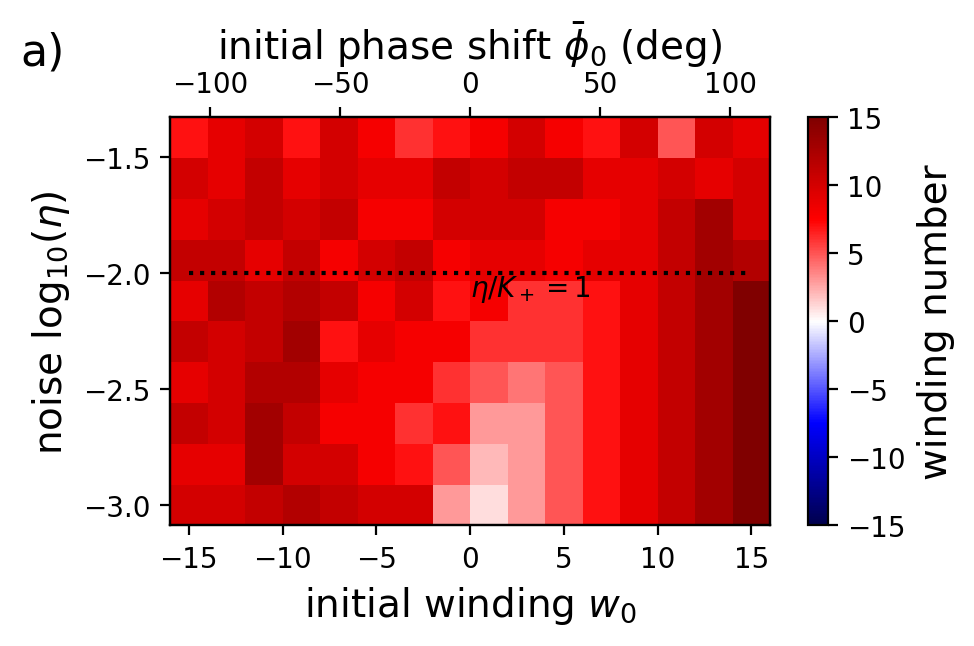

In [113]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.85)
wmax=np.max(w_arr1)
im=ax.pcolormesh(w0_arr1,np.log10(eta_arr1),w_arr1,cmap='seismic',\
                 vmin=-wmax,vmax=wmax)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'initial winding $w_0$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label('winding number',fontsize=14)
xlin=np.linspace(np.min(w0_arr1),np.max(w0_arr1),10)
ylin = 0*xlin + np.log10(nu_p1)
ax.plot(xlin,ylin,'k:')
ax.text(0,-2.1,r'$\eta/K_+=1$')

x1,x2 = ax.get_xlim()
p1 = x1*2*np.pi/N1 *180/np.pi
p2 = x2*2*np.pi/N1 *180/np.pi
ax2 = ax.twiny()
ax2.set_xlim([p1,p2])
ax2.set_xlabel(r'initial phase shift $\bar \phi_0$ (deg)',fontsize=14)

ax.text(-24,-1.1,'a)',fontsize=16)
plt.savefig('w0_DN.png',dpi=300)

phi_crit = (2*nu_p1)/nu_cm1
print('phi_crit {:.1f} deg'.format(phi_crit*180./np.pi))

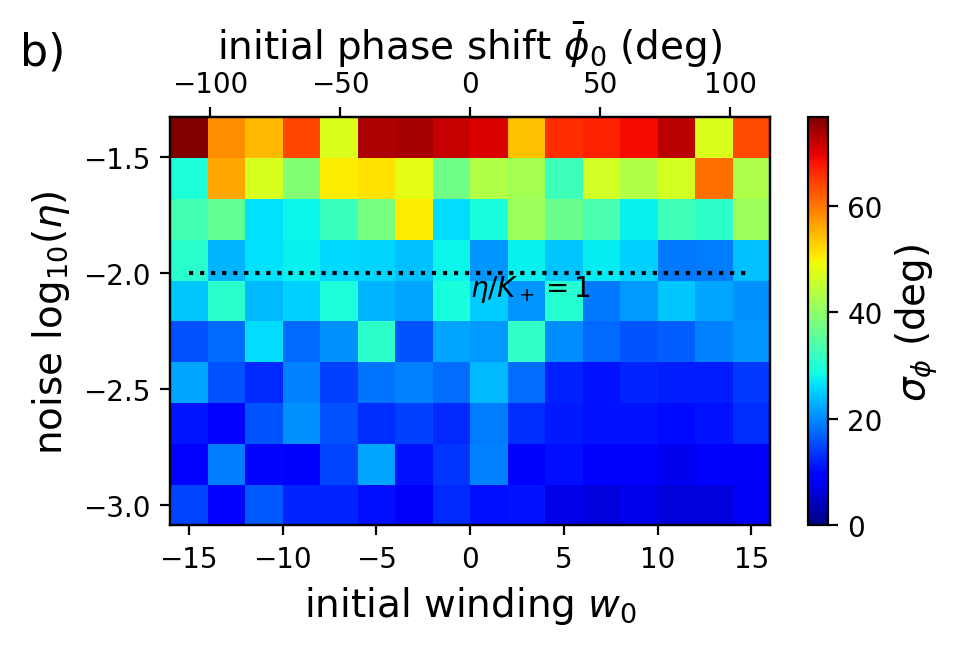

In [97]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.85)
im=ax.pcolormesh(w0_arr1,np.log10(eta_arr1),p_arr1*180/np.pi,cmap='jet',vmin=0)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'initial winding $w_0$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
xlin=np.linspace(np.min(w0_arr1),np.max(w0_arr1),10)
ylin = 0*xlin + np.log10(nu_p1)
ax.plot(xlin,ylin,'k:')
ax.text(0,-2.1,r'$\eta/K_+=1$')

x1,x2 = ax.get_xlim()
p1 = x1*2*np.pi/N1 *180/np.pi
p2 = x2*2*np.pi/N1 *180/np.pi
ax2 = ax.twiny()
ax2.set_xlim([p1,p2])
ax2.set_xlabel(r'initial phase shift $\bar \phi_0$ (deg)',fontsize=14)
ax.text(-24,-1.1,'b)',fontsize=16)
plt.savefig('w0_DN_sig.png',dpi=300)

tmax = 501
winding from 10.0  to  10.0
phisig at end 0.0524


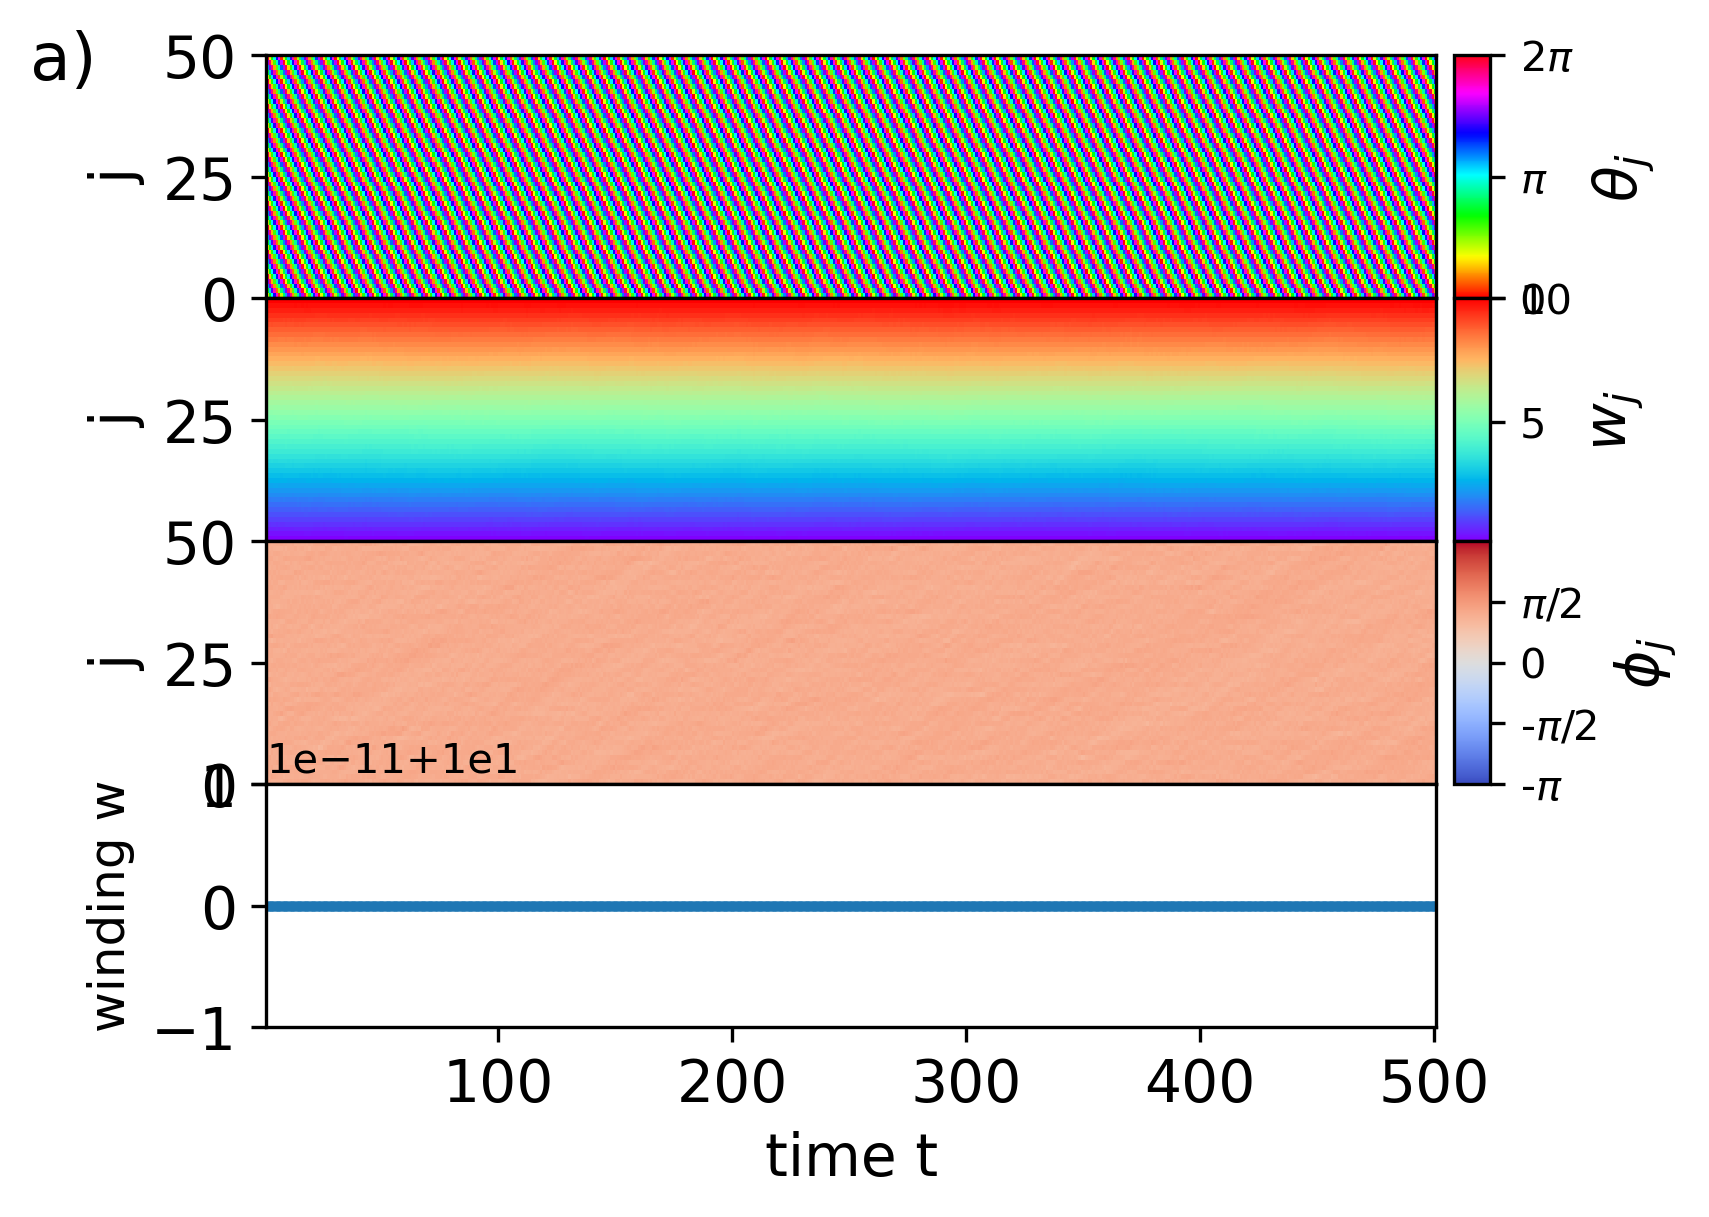

In [118]:
# lopsided niedermayer model , stochastic exploration!
Ku=0.0; hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
omega0=1.0
nu_p=0.01; nu_m=nu_p; nu_cp = 0.0; nu_cm = 0.3;
eta = 0.001  # 
parms = np.zeros(20)
parms[0] = omega0;  parms[1] = Ku; parms[2] = nu_p; parms[3] = nu_m
parms[4] = nu_cp; parms[5] = nu_cm; parms[6] = beta; parms[7] = hol;
parms[8] = A_c; parms[9] = A_s;
parms[12] = eta; 
dt=0.05
func = du_fun_overlap

# initial conditions, 
N=50; eta_rand=0*np.pi; slope_ramp = 10.0; 
mag_sin = 0.0; index_sin = 4;  phase_sin = 0.0;   peak = 0; iroll_ramp = 0
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
#plt.plot(u_arr0,'.')

ndn=500; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile=""; pos=[-100,45]; alabel="a)" 
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)
print('winding from', np.rint(winding_number[0]),' to ', np.rint(winding_number[-1]))
phisig_arr = phivar(dudj_arr)
print('phisig at end {:.4f}'.format(phisig_arr[-1]))


In [105]:
# loop over eta and initial winding number
def doloop_winit_ov(Ku,nu,N,eta_start,eta_fac,ni,nj):
    
    dt=0.05
    func = du_fun_overlap
    ndn=600; dn=20; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)
    #Ku=0.0;    
    hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
    omega0=1.0
    # initial conditions 
    eta_rand=0*np.pi; #slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 0; index_sin = 4;  phase_sin = 0.0; mag_sin = 0.;
    nu_p=nu; nu_m=nu_p; nu_cp = 0.0; nu_cm = 0.0;
    
    w0_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    eta_arr = np.zeros((ni,nj))
    p_arr = np.zeros((ni,nj))
    #half_ni = int(ni/2)
    for i in range(ni):
        slope_ramp = 2*i-ni+1  # try to do negative ones too! 
        #but index has to start with zero
        for j in range(nj):
            eta = eta_start*np.power(eta_fac,j);
            eta_arr[i,j] = eta
            
            # lopsided niedermayer model with noise
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s
            parms[12] = eta

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            u_arr0 = give_init(N,iparms) # not used
            
            uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
            print('eta={:.4f}, '.format(eta),\
                'w from {:.0f} to {:.0f}'.format(np.rint(winding_number[0])
                                                ,np.rint(winding_number[-1])))
            w0_arr[i,j] = np.rint(winding_number[0]) #initial winding number
        
            w_arr[i,j] = np.rint(winding_number[-1])  #final winding number 
            phisig_arr = phivar(dudj_arr)
            p_arr[i,j] = phisig_arr[-1]
        
    return w0_arr,eta_arr,w_arr,p_arr

 
N2=50
nu2=0.01; Ku2=0.2
eta_start = 0.001
eta_fac= 1.5
ni = 16; nj = 10  #ni for w0 
w0_arr2,eta_arr2,w_arr2,p_arr2 =doloop_winit_ov(Ku2,nu2,N2,eta_start,eta_fac,ni,nj)


tmax = 601
eta=0.0010,  w from -15 to 3
eta=0.0015,  w from -15 to 3
eta=0.0023,  w from -15 to 4
eta=0.0034,  w from -15 to 5
eta=0.0051,  w from -15 to 6
eta=0.0076,  w from -15 to 4
eta=0.0114,  w from -15 to 4
eta=0.0171,  w from -15 to 4
eta=0.0256,  w from -15 to 5
eta=0.0384,  w from -15 to 1
eta=0.0010,  w from -13 to 3
eta=0.0015,  w from -13 to 5
eta=0.0023,  w from -13 to 4
eta=0.0034,  w from -13 to 5
eta=0.0051,  w from -13 to 6
eta=0.0076,  w from -13 to 3
eta=0.0114,  w from -13 to 6
eta=0.0171,  w from -13 to 6
eta=0.0256,  w from -13 to 3
eta=0.0384,  w from -13 to 2
eta=0.0010,  w from -11 to 4
eta=0.0015,  w from -11 to 3
eta=0.0023,  w from -11 to 4
eta=0.0034,  w from -11 to 4
eta=0.0051,  w from -11 to 6
eta=0.0076,  w from -11 to 5
eta=0.0114,  w from -11 to 4
eta=0.0171,  w from -11 to 5
eta=0.0256,  w from -11 to 5
eta=0.0384,  w from -11 to 2
eta=0.0010,  w from -9 to 3
eta=0.0015,  w from -9 to 3
eta=0.0023,  w from -9 to 3
eta=0.0034,  w from -9 to 4
eta=0.0

phi_crit 0.21 deg


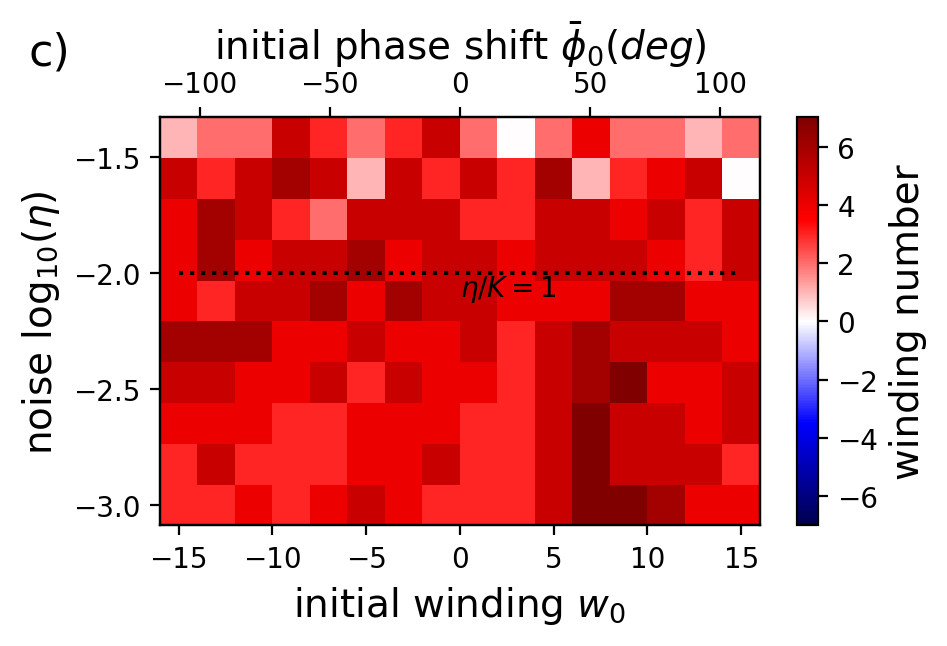

In [115]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.85)
wmax = np.max(w_arr2)
im=ax.pcolormesh(w0_arr2,np.log10(eta_arr2),w_arr2,cmap='seismic',\
                 vmin=-wmax,vmax=wmax)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'initial winding $w_0$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label('winding number',fontsize=14)
xlin=np.linspace(np.min(w0_arr2),np.max(w0_arr2),10)
ylin = 0*xlin + np.log10(nu2)
ax.plot(xlin,ylin,'k:')
ax.text(0,-2.1,r'$\eta/K=1$')

x1,x2 = ax.get_xlim()
p1 = x1*2*np.pi/N2 *180/np.pi
p2 = x2*2*np.pi/N2 *180/np.pi
ax2 = ax.twiny()
ax2.set_xlim([p1,p2])
ax2.set_xlabel(r'initial phase shift $\bar \phi_0 (deg)$',fontsize=14)
ax.text(-23,-1.1,'c)',fontsize=16)
plt.savefig('w0_OVN.png',dpi=300)

hol=0.05; beta=0.1; omega0=1.0
c2a = Ku2*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
phi_crit = 2*nu2/c2a
print('phi_crit {:.2f} deg'.format(phi_crit*180./np.pi))

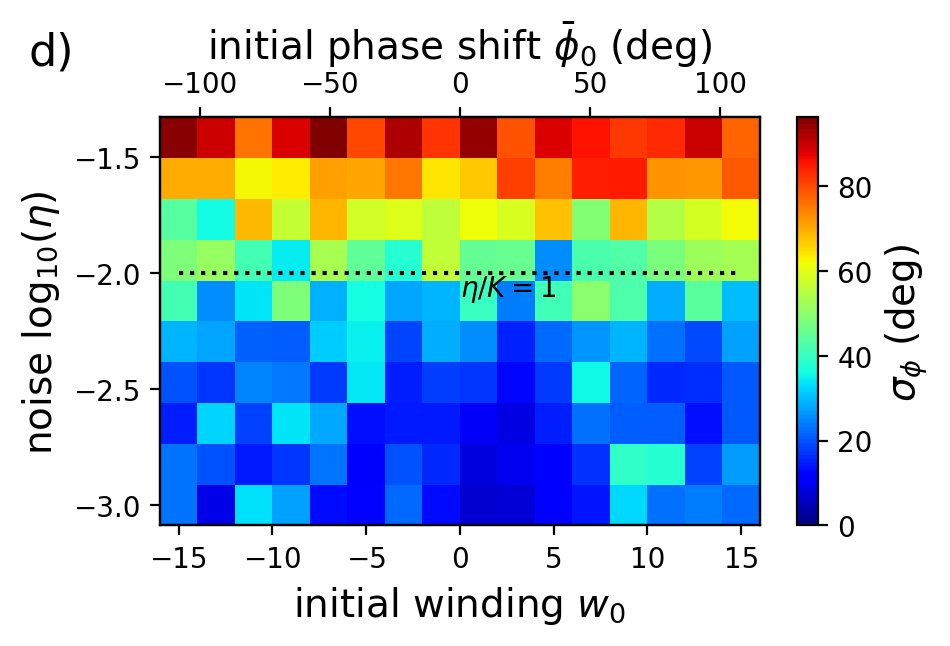

In [108]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.85)
im=ax.pcolormesh(w0_arr2,np.log10(eta_arr2),p_arr2*180/np.pi,cmap='jet',vmin=0)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'initial winding $w_0$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
xlin=np.linspace(np.min(w0_arr2),np.max(w0_arr2),10)
ylin = 0*xlin + np.log10(nu2)
ax.plot(xlin,ylin,'k:')
ax.text(0,-2.1,r'$\eta/K=1$')

x1,x2 = ax.get_xlim()
p1 = x1*2*np.pi/N2 *180/np.pi
p2 = x2*2*np.pi/N2 *180/np.pi
ax2 = ax.twiny()
ax2.set_xlim([p1,p2])
ax2.set_xlabel(r'initial phase shift $\bar \phi_0$ (deg)',fontsize=14)
ax.text(-23,-1.1,'d)',fontsize=16)
plt.savefig('w0_OVN_sig.png',dpi=300)

tmax = 1001
winding from 0.0  to  72.0
phisig at end 9.5097 deg


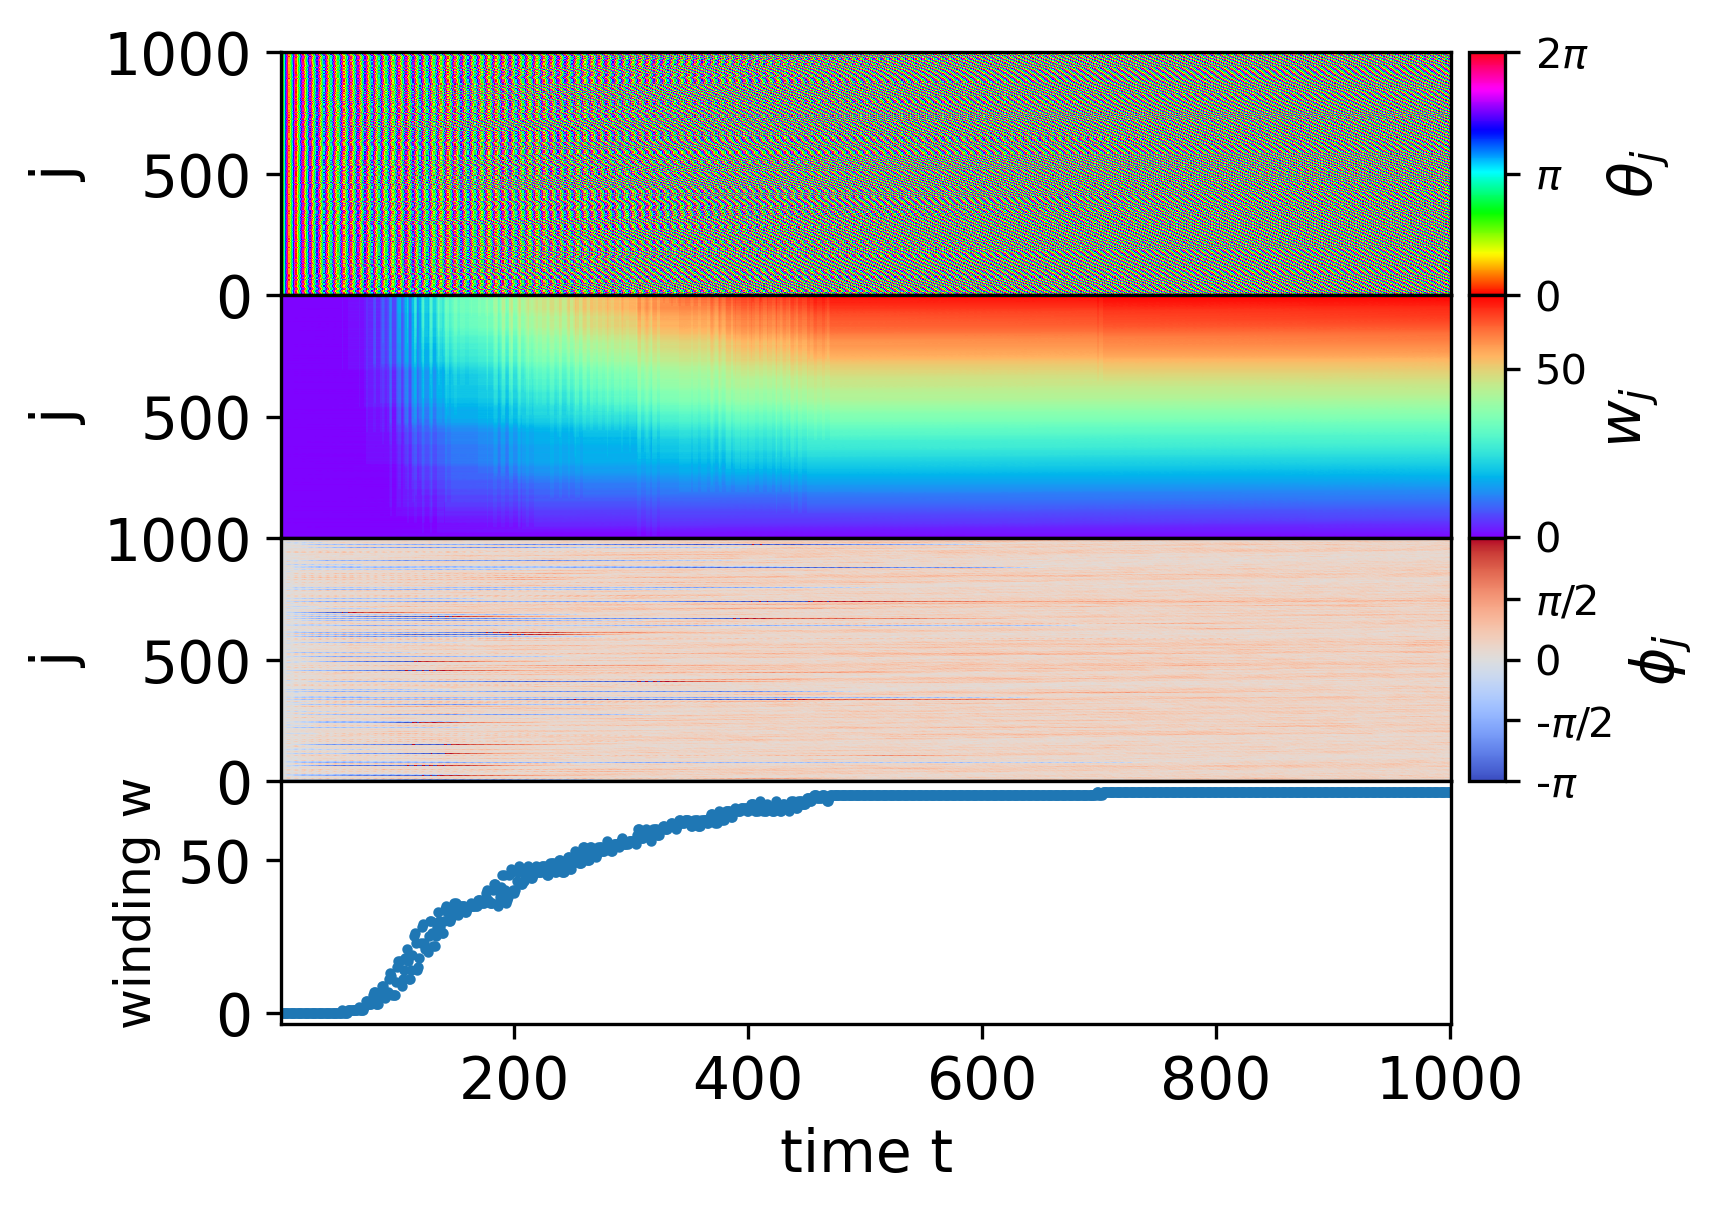

In [129]:
# mod lopsided ov  model , stochastic exploration!
Ku=0.2; hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
omega0=1.0
nu_p=0.01; nu_m=nu_p; nu_cp = 0.0; nu_cm = 0.0;
eta = 0.001  # 
parms = np.zeros(20)
parms[0] = omega0;  parms[1] = Ku; parms[2] = nu_p; parms[3] = nu_m
parms[4] = nu_cp; parms[5] = nu_cm; parms[6] = beta; parms[7] = hol;
parms[8] = A_c; parms[9] = A_s;
parms[12] = eta; 
dt=0.05
func = du_fun_overlap

# initial conditions, 
N=1000; eta_rand=0*np.pi; slope_ramp = 0.0; 
mag_sin = 0.0; index_sin = 4;  phase_sin = 0.0;   peak = 0; iroll_ramp = 0
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
#u_arr0 = give_init(N,iparms)
#plt.plot(u_arr0,'.')

ndn=1000; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile=""; pos=[-100,N]; alabel="" 
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)
print('winding from', np.rint(winding_number[0]),' to ', np.rint(winding_number[-1]))
phisig_arr = phivar(dudj_arr)
print('phisig at end {:.4f} deg'.format(phisig_arr[-1]*180/np.pi))

In [130]:
np.log2(2)

1.0